In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import math, re, os 
import numpy as np
import tensorflow as tf

In [3]:
print(tf.__version__)

2.2.0


In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH=KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)

gs://kds-75edbd4028d0189b2f54cd52e93f98ae696162b25ccc0bde56335eec


In [6]:
IMAGE_SIZE=[512,512]
GCS_PATH=GCS_DS_PATH+'/tfrecords-jpeg-512x512'
AUTO=tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data,channels=3)
    image = tf.cast(image,tf.float32)/255.0 
    # concert image to floats [0,1,] range
    image=tf.reshape(image,[*IMAGE_SIZE,3])
    # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([],tf.string),
        # tf.string means bytestring
        "class": tf.io.FixedLenFeature([],tf.int64)
        # shape [] means single element
        
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image,label  # returns a dataset of image(s)


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([],tf.string),
        # tf.string means bytestring
        "id": tf.io.FixedLenFeature([],tf.string)
        # shape [] means single element
        
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)



def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords, For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    
    ignore_order=tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic =False
        # disable order, increase speed
        
    dataset=tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
        # automatically interleaves reads from multiple files
    dataset=dataset.with_options(ignore_order)
        # uses data as soon as it strams it, rather than in its original order
    dataset=dataset.map(read_labeled_tfrecord if labeled else
                           read_unlabeled_tfrecord, num_parallel_calls=AUTO)
        # returns a dataset of (image, label) pairs if labeled=True 
        # or (image, id) pairs if labeled=False 
    return dataset

In [7]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image= tf.image.random_crop(image, size=[512,512,3])
    image=tf.image.random_flip_left_right(image)
    
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label 
def get_training_dataset():
    dataset=load_dataset(TRAINING_FILENAMES,labeled=True)
    dataset= dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset=dataset.repeat()
    # the training dataset must repeat for several epochs
    dataset=dataset.shuffle(2048)
    dataset=dataset.batch(BATCH_SIZE)
    dataset=dataset.prefetch(AUTO)
    # prefetch next batch while training (autotune prefetch buffer size)
    return dataset 

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset
def get_test_dataset(ordered=False):
    dataset=load_dataset(TEST_FILENAMES,labeled=False, ordered=ordered)
    dataset=dataset.batch(BATCH_SIZE)
    dataset=dataset.prefetch(AUTO)
    # prefetch next batch while training (autotune prefetch buffer size)
    return dataset 

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'
     .format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES,NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
# Define the batch size. This will be 16 with TPU off and 128
# (=16*8) with TPU on 
BATCH_SIZE = 16*strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training: ",ds_train)
print("Validation: ",ds_valid)
print("Test: ",ds_test)

Training:  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Validation:  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Test:  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image,label in ds_train.take(3):
    print(image.numpy().shape,label.numpy().shape)
print("Training data label examples:",label.numpy())

Training data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Training data label examples: [ 13  48   1 ... 103  24   4]


In [10]:
print("Test data shapes:")
for image,idnum in ds_test.take(3):
    print(image.numpy().shape,idnum.numpy().shape)
print("Test data IDs:",idnum.numpy().astype('U'))

Test data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


In [11]:
import matplotlib.pyplot as plt 

def batch_to_numpy_images_and_labels(data):
    images, labels = data 
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    if numpy_labels.dtype ==object:
        # binary string in this case,
        # these are image ID strings 
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels 
    # (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True 
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 
                               'NO', u"\u2192" if not correct else '',
                               CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title)>0:
        plt.title(title, fontsize=int(titlesize) if not red
                 else int(titlesize/1.2), color ='red' if red else
                 'black',fontdict={'verticalalignment':'center'},
                 pad = int(titlesize/1.5))
    return (subplot[0],subplot[1],subplot[2]+1)


def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images,predictions)
    display_batch_of_images((images,labels))
    display_batch_of_images((images,labels), predictions)
    """
    # data
    images,labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit in to square
    # or square-ish rectangle 
    rows=int(math.sqrt(len(images)))
    cols =len(images)//rows 
    
    
    # size and spacing 
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot =(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols],labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True 
        if predictions is not None:
            title, correct =title_from_label_and_target(predictions[i],label)
        dynamic_titlesize=FIGSIZE*SPACING/max(rows,cols)*40+3
    # magic formula tested to work from 1x1 to 10*10 unages
        subplot=display_one_flower(image, title, subplot, 
                                  not correct, titlesize=dynamic_titlesize)
        
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspce=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=0, hspace=SPACING)
    plt.show()
        
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10),facecolor='#F0F0F0')
        plt.tight_layout()
    ax=plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model' + title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train','valid'])

In [12]:
ds_iter = iter(ds_train.unbatch().batch(20))

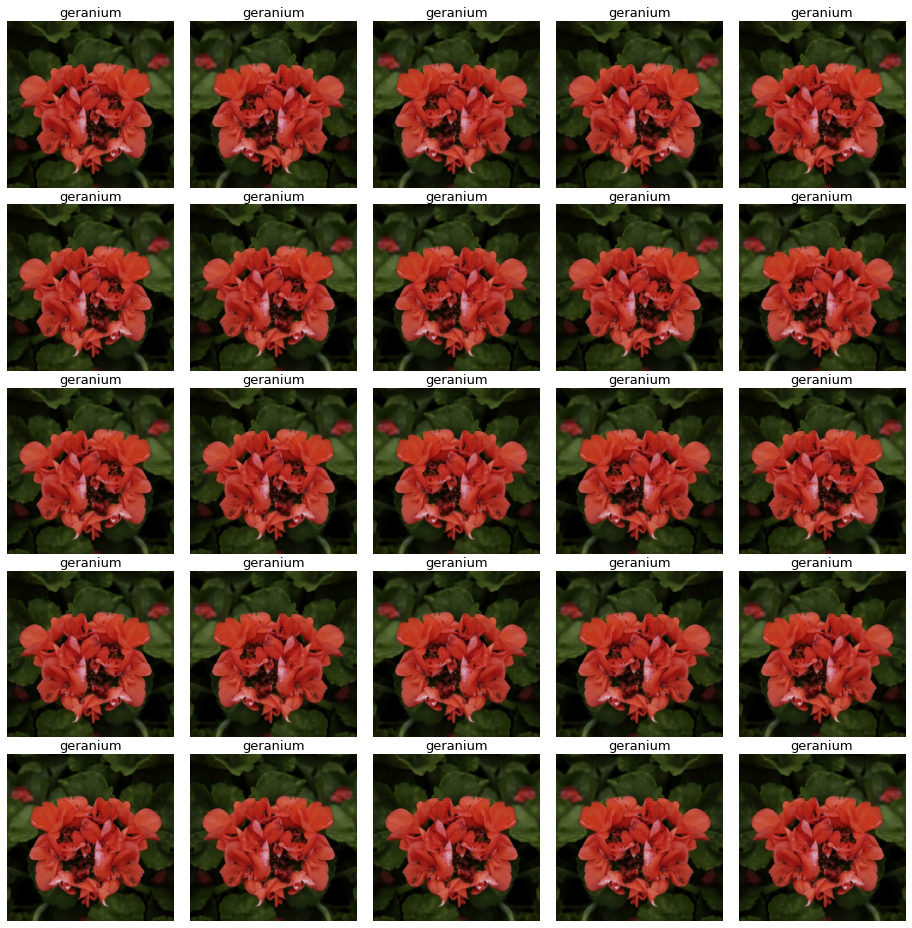

In [13]:
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
one_element = tf.data.Dataset.from_tensors( next(iter(dataset)) )
augmented_element = one_element.repeat().map(data_augment).batch(25)

display_batch_of_images(next(iter(augmented_element)))

In [14]:
EPOCHS = 50
with strategy.scope():
    pretained_model=tf.keras.applications.ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=[*IMAGE_SIZE,3]
    )
    pretained_model.trainable = False
    model = tf.keras.Sequential([
        pretained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),                             
        tf.keras.layers.Dense(len(CLASSES),activation='softmax')])
    

234553344/234545216 [==============================] - 2s 0us/step


In [15]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 58,544,744
Trainable params: 213,096
Non-trainable params: 58,331,648
_________________________________________________________________


Learning rate schedule: 1e-05 to 5e-05 to 1e-05


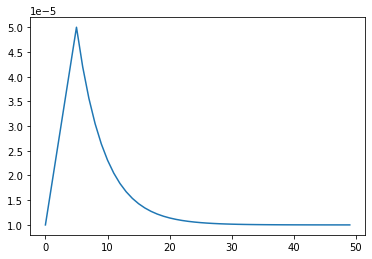

In [16]:
# Learning Rate Schedule for Fine Tuning # 
def exponential_lr(epoch,
                  start_lr=0.00001,min_lr=0.00001,max_lr=0.00005,
                  rampup_epochs = 5, sustain_epochs = 0,
                  exp_decay = 0.8):
    def lr(epoch, start_lr, min_lr,max_lr,rampup_epochs,sustain_epochs,
          exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr= ((max_lr-start_lr)/
                rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr 
        else:
            lr = ((max_lr - min_lr)* exp_decay ** (epoch-rampup_epochs-sustain_epochs)
                  + min_lr)
            
        return lr
    return lr(epoch,start_lr,min_lr,max_lr,rampup_epochs,sustain_epochs,exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr,verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng,y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0],
                                                                 max(y),
                                                                 y[-1]))

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping =EarlyStopping()

In [ ]:
# Define training epochs
EPOCHS = 50
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES//BATCH_SIZE

history = model.fit(ds_train,validation_data=ds_valid,
                   epochs=EPOCHS,
                   steps_per_epoch=STEPS_PER_EPOCH,callbacks=[lr_callback]
                   )



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
99/99 [==============================] - 30s 304ms/step - sparse_categorical_accuracy: 0.3991 - loss: 2.6472 - val_sparse_categorical_accuracy: 0.6277 - val_loss: 1.5932 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
Epoch 2/50
99/99 [==============================] - 10s 98ms/step - sparse_categorical_accuracy: 0.6636 - loss: 1.3780 - val_sparse_categorical_accuracy: 0.6975 - val_loss: 1.2725 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
Epoch 3/50
99/99 [==============================] - 9s 91ms/step - sparse_categorical_accuracy: 0.7315 - loss: 1.0981 - val_sparse_categorical_accuracy: 0.7228 - val_loss: 1.1622 - lr: 5.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
Epoch 4/50
99/99 [==============================] - 9s 90ms/step - spars

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
212)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat,score,precision,recall):
    plt.figure(figsize=(15,15))
    ax=plt.gca()
    ax.matshow(cmat, cmap='Blues')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_xticklabels(),rotation=45,ha="left",rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_yticklabels(),rotation=45,ha="right",rotation_mode="anchor")
    titlestring= ""
    if score is not None:
        titlestring +='f1 ={:.3f}'.format(score)
    if precision is not None:
        titlestring +='\nprecision = {:.3f}'.format(precision)
    if recall is not None:
        titlestring +='\nrecall = {:.3f}'.format(recall)
    if len(titlestring)> 0:
        ax.text(101,1,titlestring,fontdict={
            'fontsize':18,
            'horizontalalignment':'right',
            'verticalalignment':'top',
            'color':'#804040'
        })
    plt.show()
    
def display_training_curves(training,validation,title,subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10),facecolor='#F0F0F0')
        plt.tight_layout()
    ax=plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model'+title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train','valid'])

In [ ]:
cmdataset=get_validation_dataset(ordered=True)
image_ds=cmdataset.map(lambda image, label:image)
labels_ds=cmdataset.map(lambda image, label:label).unbatch()

cm_correct_labels=next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities=model.predict(image_ds)
cm_predictions = np.argmax(cm_probabilities,axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,)
cmat= (cmat.T/cmat.sum(axis=1)).T #normalize

In [ ]:
score=f1_score(cm_correct_labels,cm_predictions,labels=labels,average='macro')
precision=precision_score(cm_correct_labels,cm_predictions,labels=labels,average='macro')
recall=recall_score(cm_correct_labels,cm_predictions,labels=labels,average='macro')
display_confusion_matrix(cmat,score,precision,recall)

In [ ]:
dataset=get_validation_dataset()
dataset=dataset.unbatch().batch(20)
batch=iter(dataset)

In [ ]:
images, labels=next(batch)
probabilities= model.predict(images)
predictions=np.argmax(probabilities,axis=-1)
display_batch_of_images((images,labels),predictions)

In [ ]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds=test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions=np.argmax(probabilities,axis=-1)
print(predictions)

In [ ]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode 
test_ids_ds =test_ds.map(lambda image,idnum:idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt('submission.csv',np.rec.fromarrays([test_ids,predictions]),
          fmt=['%s', '%d'],
          delimiter=',',
          header='id,label',
          comments='',)


!head submssion.csv